In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# STEP 1: DATA LOADING


In [ ]:
def load_monthly_data(base_folder_path):
    """
    Loads all .csv.gz files from monthly subfolders within a base folder
    into a single pandas DataFrame.

    Args:
        base_folder_path: The path to the base folder (e.g., "NASA/326").

    Returns:
        A pandas DataFrame containing the concatenated data from all files.
    """
    all_dataframes = []

    full_base_path = os.path.join(base_folder_path)

    # Check if path exists
    if not os.path.exists(full_base_path):
        print(f"Warning: Path {full_base_path} does not exist")
        return pd.DataFrame()

    all_entries = os.listdir(full_base_path)
    month_folders = [entry for entry in all_entries if os.path.isdir(os.path.join(full_base_path, entry))]

    print(f"Loading data from {base_folder_path}...")
    print(f"Found {len(month_folders)} month folders")

    for month_folder in month_folders:
        month_folder_path = os.path.join(full_base_path, month_folder)
        month_entries = os.listdir(month_folder_path)
        csv_files = [entry for entry in month_entries if entry.endswith('.csv.gz')]

        for csv_file in csv_files:
            file_path = os.path.join(month_folder_path, csv_file)
            try:
                df_month = pd.read_csv(file_path, compression='gzip')
                all_dataframes.append(df_month)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Loaded {len(combined_df)} rows")
    else:
        combined_df = pd.DataFrame()
        print("No data loaded")

    return combined_df

In [ ]:
df=load_monthly_data('/content/drive/MyDrive/NASA/OPENAQ_DATA/326')
df.head()

Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/326...
Found 9 month folders
Loaded 31226 rows


,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,326,30082,Jackson NCORE-326,2025-09-02T01:00:00-05:00,32.329042,-90.182659,pm10,µg/m³,13.0
1,326,30082,Jackson NCORE-326,2025-09-02T02:00:00-05:00,32.329042,-90.182659,pm10,µg/m³,13.0
2,326,30082,Jackson NCORE-326,2025-09-02T03:00:00-05:00,32.329042,-90.182659,pm10,µg/m³,14.0
3,326,30082,Jackson NCORE-326,2025-09-02T04:00:00-05:00,32.329042,-90.182659,pm10,µg/m³,19.0
4,326,30082,Jackson NCORE-326,2025-09-02T05:00:00-05:00,32.329042,-90.182659,pm10,µg/m³,17.0


In [ ]:
def load_multiple_locations(base_folder_path):
    """
    Load data from multiple location folders within a base folder.

    Args:
        base_folder_path: The path to the base folder containing location subfolders.

    Returns:
        Dictionary with location_id as key and DataFrame as value
    """
    location_data = {}

    # List all entries in the base folder
    all_entries = os.listdir(base_folder_path)

    # Filter for directories (subfolders)
    location_folders = [os.path.join(base_folder_path, entry) for entry in all_entries if os.path.isdir(os.path.join(base_folder_path, entry))]

    print(f"Found {len(location_folders)} location folders in {base_folder_path}")

    for folder_path in location_folders:
        print(f"Processing folder: {folder_path}")
        df = load_monthly_data(folder_path)

        if not df.empty:
            # Assuming 'location_id' and 'location' columns exist and are consistent within a location's data
            location_id = df['location_id'].iloc[0]
            location_name = df['location'].iloc[0]
            location_data[location_id] = {
                'data': df,
                'name': location_name,
                'path': folder_path
            }
            print(f"✓ Loaded {location_name} (ID: {location_id}): {len(df)} rows\n")

    return location_data

In [ ]:
location_dict = load_multiple_locations('/content/drive/MyDrive/NASA/OPENAQ_DATA')

Found 4 location folders in /content/drive/MyDrive/NASA/OPENAQ_DATA
Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/1227
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/1227...
Found 9 month folders
Loaded 12886 rows
✓ Loaded Kona-1227 (ID: 1227): 12886 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/326
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/326...
Found 9 month folders
Loaded 31226 rows
✓ Loaded Jackson NCORE-326 (ID: 326): 31226 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/1531
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/1531...
Found 9 month folders
Loaded 25948 rows
✓ Loaded Big Piney-1531 (ID: 1531): 25948 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/.ipynb_checkpoints
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/.ipynb_checkpoints...
Found 0 month folders
No data loaded


In [ ]:
df_1531 = location_dict[1531]['data']
df_1227 = location_dict[1227]['data']
df_326 = location_dict[326]['data']
display(df_1531.head())

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,1531,2695,Big Piney-1531,2025-08-10T01:00:00-06:00,42.486668,-110.099167,no2,ppm,0.0
1,1531,2695,Big Piney-1531,2025-08-10T02:00:00-06:00,42.486668,-110.099167,no2,ppm,0.0
2,1531,2695,Big Piney-1531,2025-08-10T03:00:00-06:00,42.486668,-110.099167,no2,ppm,0.0
3,1531,2695,Big Piney-1531,2025-08-10T04:00:00-06:00,42.486668,-110.099167,no2,ppm,0.0
4,1531,2695,Big Piney-1531,2025-08-10T05:00:00-06:00,42.486668,-110.099167,no2,ppm,0.0


# STEP 2: DATA TRANSFORMATION TO WIDE FORMAT

In [ ]:
KEY_PARAMETERS = ['pm10', 'pm25', 'co', 'so2', 'o3', 'no2']


In [ ]:
def filter_key_parameters(df, key_parameters=KEY_PARAMETERS):
    """
    Filter dataframe to keep only key air quality parameters.
    Removes all rows with parameters not in the key list.

    Args:
        df: DataFrame in long format with 'parameter' column
        key_parameters: List of parameters to keep

    Returns:
        Filtered DataFrame, or None if no key parameters exist
    """
    # Check which key parameters exist in this location
    available_key_params = df[df['parameter'].isin(key_parameters)]['parameter'].unique()

    if len(available_key_params) == 0:
        # Location has NONE of the key parameters
        return None, []

    # Filter to keep only key parameters
    df_filtered = df[df['parameter'].isin(key_parameters)].copy()

    print(f"  Original parameters: {df['parameter'].unique().tolist()}")
    print(f"  Kept key parameters: {available_key_params.tolist()}")
    print(f"  Rows: {len(df)} → {len(df_filtered)}")

    return df_filtered, available_key_params.tolist()


In [ ]:
a,b=filter_key_parameters(df_1531)
print(a.head())
print(b)

  Original parameters: ['no2', 'o3', 'no', 'nox']
  Kept key parameters: ['no2', 'o3']
  Rows: 25948 → 12970
   location_id  sensors_id        location                   datetime  \
0         1531        2695  Big Piney-1531  2025-08-10T01:00:00-06:00   
1         1531        2695  Big Piney-1531  2025-08-10T02:00:00-06:00   
2         1531        2695  Big Piney-1531  2025-08-10T03:00:00-06:00   
3         1531        2695  Big Piney-1531  2025-08-10T04:00:00-06:00   
4         1531        2695  Big Piney-1531  2025-08-10T05:00:00-06:00   

         lat         lon parameter units  value  
0  42.486668 -110.099167       no2   ppm    0.0  
1  42.486668 -110.099167       no2   ppm    0.0  
2  42.486668 -110.099167       no2   ppm    0.0  
3  42.486668 -110.099167       no2   ppm    0.0  
4  42.486668 -110.099167       no2   ppm    0.0  
['no2', 'o3']


In [ ]:
a,b=filter_key_parameters(df_1227)
print(a.head())
print(b)

  Original parameters: ['pm25', 'so2']
  Kept key parameters: ['pm25', 'so2']
  Rows: 12886 → 12886
   location_id  sensors_id   location                   datetime      lat  \
0         1227        2202  Kona-1227  2025-04-01T01:00:00-10:00  19.5097   
1         1227        2202  Kona-1227  2025-04-01T02:00:00-10:00  19.5097   
2         1227        2202  Kona-1227  2025-04-01T03:00:00-10:00  19.5097   
3         1227        2202  Kona-1227  2025-04-01T04:00:00-10:00  19.5097   
4         1227        2202  Kona-1227  2025-04-01T05:00:00-10:00  19.5097   

        lon parameter  units  value  
0 -155.9133      pm25  µg/m³    0.0  
1 -155.9133      pm25  µg/m³    5.0  
2 -155.9133      pm25  µg/m³    4.0  
3 -155.9133      pm25  µg/m³    2.0  
4 -155.9133      pm25  µg/m³    4.0  
['pm25', 'so2']


In [ ]:
a,b=filter_key_parameters(df_326)
print(a.head())
print(b)

  Original parameters: ['pm10', 'pm25', 'co', 'so2', 'o3']
  Kept key parameters: ['pm10', 'pm25', 'co', 'so2', 'o3']
  Rows: 31226 → 31226
   location_id  sensors_id           location                   datetime  \
0          326       30082  Jackson NCORE-326  2025-09-02T01:00:00-05:00   
1          326       30082  Jackson NCORE-326  2025-09-02T02:00:00-05:00   
2          326       30082  Jackson NCORE-326  2025-09-02T03:00:00-05:00   
3          326       30082  Jackson NCORE-326  2025-09-02T04:00:00-05:00   
4          326       30082  Jackson NCORE-326  2025-09-02T05:00:00-05:00   

         lat        lon parameter  units  value  
0  32.329042 -90.182659      pm10  µg/m³   13.0  
1  32.329042 -90.182659      pm10  µg/m³   13.0  
2  32.329042 -90.182659      pm10  µg/m³   14.0  
3  32.329042 -90.182659      pm10  µg/m³   19.0  
4  32.329042 -90.182659      pm10  µg/m³   17.0  
['pm10', 'pm25', 'co', 'so2', 'o3']


In [ ]:
def prepare_location_data(df, key_parameters=KEY_PARAMETERS):
    """
    Transform long format to wide format with standardized columns.
    First filters to keep only key parameters, then ensures ALL key parameter
    columns exist (fills with NaN if missing).

    Args:
        df: DataFrame in long format with 'parameter' and 'value' columns
        key_parameters: List of key parameters to model

    Returns:
        DataFrame in wide format with columns for each key parameter, or None
        List of available parameters
    """
    # STEP 1: Filter to keep only key parameters
    df_filtered, available_params = filter_key_parameters(df, key_parameters)

    if df_filtered is None:
        print(f"  ⚠️  Location has NONE of the key parameters - SKIPPING")
        return None, []
    # STEP 2: Convert datetime to proper format
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

    # STEP 3: Pivot to wide format
    df_wide = df.pivot_table(
        index=['location_id', 'location', 'datetime', 'lat', 'lon'],
        columns='parameter',
        values='value',
        aggfunc='first'  # In case of duplicates, take first value
    ).reset_index()

    # STEP 4: Ensure ALL key parameter columns exist (even if not measured)

    for param in key_parameters:
        if param not in df_wide.columns:
            df_wide[param] = np.nan

    # STEP 5: Reorder columns for consistency
    base_cols = ['location_id', 'location', 'datetime', 'lat', 'lon']
    df_wide = df_wide[base_cols + key_parameters]


    # Sort by datetime
    df_wide = df_wide.sort_values(['location_id', 'datetime']).reset_index(drop=True)
    print(f"  ✓ Wide format shape: {df_wide.shape}")

    print(f"  Parameters available: {available_params}")
    print(f"  Shape before transformation: {df.shape}")
    print(f"  Shape after transformation: {df_wide.shape}")

    return df_wide, available_params

In [ ]:
prepare_location_data(df_1531)

  Original parameters: ['no2', 'o3', 'no', 'nox']
  Kept key parameters: ['no2', 'o3']
  Rows: 25948 → 12970
  ✓ Wide format shape: (6489, 11)
  Parameters available: ['no2', 'o3']
  Shape before transformation: (25948, 9)
  Shape after transformation: (6489, 11)


(parameter  location_id        location                  datetime        lat  \
 0                 1531  Big Piney-1531 2025-01-01 08:00:00+00:00  42.486668   
 1                 1531  Big Piney-1531 2025-01-01 09:00:00+00:00  42.486668   
 2                 1531  Big Piney-1531 2025-01-01 10:00:00+00:00  42.486668   
 3                 1531  Big Piney-1531 2025-01-01 11:00:00+00:00  42.486668   
 4                 1531  Big Piney-1531 2025-01-01 12:00:00+00:00  42.486668   
 ...                ...             ...                       ...        ...   
 6484              1531  Big Piney-1531 2025-09-30 02:00:00+00:00  42.486668   
 6485              1531  Big Piney-1531 2025-09-30 03:00:00+00:00  42.486668   
 6486              1531  Big Piney-1531 2025-09-30 04:00:00+00:00  42.486668   
 6487              1531  Big Piney-1531 2025-09-30 05:00:00+00:00  42.486668   
 6488              1531  Big Piney-1531 2025-09-30 06:00:00+00:00  42.486668   
 
 parameter         lon  pm10  pm25  co

In [ ]:
def combine_all_locations(location_data, key_parameters=KEY_PARAMETERS):
    """
    Combine all location dataframes into one standardized dataframe.
    Skips locations that have NONE of the key parameters.

    Args:
        location_data: Dictionary from load_multiple_locations()
        key_parameters: List of key parameters to model

    Returns:
        combined_df: Single DataFrame with all locations
        location_metadata: Dictionary tracking available parameters per location
        skipped_locations: List of location IDs that were skipped
    """
    all_dfs = []
    location_metadata = {}
    skipped_locations = []

    print("\n" + "="*70)
    print("TRANSFORMING TO WIDE FORMAT")
    print(f"Key parameters: {key_parameters}")
    print("="*70)

    for location_id, loc_info in location_data.items():
        print(f"\nProcessing {loc_info['name']} (ID: {location_id})...")
        df_wide, available_params = prepare_location_data(loc_info['data'], key_parameters)

        if df_wide is None:
            # Location has none of the key parameters - skip it
            skipped_locations.append({
                'id': location_id,
                'name': loc_info['name'],
                'reason': 'No key parameters available'
            })
            print(f"  → SKIPPED (will not be included in model)")
            continue

        all_dfs.append(df_wide)

        location_metadata[location_id] = {
            'name': loc_info['name'],
            'parameters': available_params
        }

    if not all_dfs:
        print("\n⚠️  WARNING: No locations have any of the key parameters!")
        return None, {}, skipped_locations

    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df = combined_df.sort_values(['location_id', 'datetime']).reset_index(drop=True)

    print("\n" + "="*70)
    print(f"COMBINED DATAFRAME: {combined_df.shape}")
    print(f"Included locations: {len(location_metadata)}")
    print(f"Skipped locations: {len(skipped_locations)}")
    print("="*70)

    if skipped_locations:
        print("\nSkipped locations:")
        for loc in skipped_locations:
            print(f"  - {loc['name']} (ID: {loc['id']}): {loc['reason']}")

    return combined_df, location_metadata, skipped_locations

In [ ]:
combined_df, location_meta, skipped_locations =combine_all_locations(location_dict)


TRANSFORMING TO WIDE FORMAT
Key parameters: ['pm10', 'pm25', 'co', 'so2', 'o3', 'no2']

Processing Kona-1227 (ID: 1227)...
  Original parameters: ['pm25', 'so2']
  Kept key parameters: ['pm25', 'so2']
  Rows: 12886 → 12886
  ✓ Wide format shape: (6501, 11)
  Parameters available: ['pm25', 'so2']
  Shape before transformation: (12886, 9)
  Shape after transformation: (6501, 11)

Processing Jackson NCORE-326 (ID: 326)...
  Original parameters: ['pm10', 'pm25', 'co', 'so2', 'o3']
  Kept key parameters: ['pm10', 'pm25', 'co', 'so2', 'o3']
  Rows: 31226 → 31226
  ✓ Wide format shape: (6396, 11)
  Parameters available: ['pm10', 'pm25', 'co', 'so2', 'o3']
  Shape before transformation: (31226, 9)
  Shape after transformation: (6396, 11)

Processing Big Piney-1531 (ID: 1531)...
  Original parameters: ['no2', 'o3', 'no', 'nox']
  Kept key parameters: ['no2', 'o3']
  Rows: 25948 → 12970
  ✓ Wide format shape: (6489, 11)
  Parameters available: ['no2', 'o3']
  Shape before transformation: (25948

In [ ]:
combined_df.head()

parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,no2
0,326,Jackson NCORE-326,2025-01-01 07:00:00+00:00,32.329042,-90.182659,15.0,9.8,0.2,0.0015,0.025,NaN
1,326,Jackson NCORE-326,2025-01-01 08:00:00+00:00,32.329042,-90.182659,14.0,9.3,0.3,0.0015,0.012,NaN
2,326,Jackson NCORE-326,2025-01-01 09:00:00+00:00,32.329042,-90.182659,16.0,10.6,0.3,0.0015,0.016,NaN
3,326,Jackson NCORE-326,2025-01-01 10:00:00+00:00,32.329042,-90.182659,11.0,7.5,0.3,0.0014,0.014,NaN
4,326,Jackson NCORE-326,2025-01-01 11:00:00+00:00,32.329042,-90.182659,10.0,6.6,0.3,0.0014,0.012,NaN


In [ ]:
import plotly.express as px

# Filter data for the first 7 days
start_date = combined_df['datetime'].min()
end_date = start_date + pd.Timedelta(days=7)
df_7days = combined_df[(combined_df['datetime'] >= start_date) & (combined_df['datetime'] < end_date)].copy()


timeseries_plot = px.line(df_7days, x = 'datetime', y = 'o3', color='location',
                                title = "pm25 polution (First 7 Days)")
timeseries_plot.show()

In [ ]:
#combined_df.to_csv('/content/drive/MyDrive/NASA/OPENAQ_DATA/Combined_data.csv')

# STEP 3: FEATURE ENGINEERING

In [ ]:
def create_temporal_features(df):
    """
    Create temporal features from datetime column.
    """
    df = df.copy()
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Cyclical encoding for hour (captures 23h -> 0h continuity)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    return df

In [ ]:
temporal_df=create_temporal_features(combined_df)
temporal_df.head()

parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,no2,hour,day_of_week,day_of_month,month,is_weekend,hour_sin,hour_cos
0,326,Jackson NCORE-326,2025-01-01 07:00:00+00:00,32.329042,-90.182659,15.0,9.8,0.2,0.0015,0.025,NaN,7,2,1,1,0,0.965926,-0.258819
1,326,Jackson NCORE-326,2025-01-01 08:00:00+00:00,32.329042,-90.182659,14.0,9.3,0.3,0.0015,0.012,NaN,8,2,1,1,0,0.866025,-0.500000
2,326,Jackson NCORE-326,2025-01-01 09:00:00+00:00,32.329042,-90.182659,16.0,10.6,0.3,0.0015,0.016,NaN,9,2,1,1,0,0.707107,-0.707107
3,326,Jackson NCORE-326,2025-01-01 10:00:00+00:00,32.329042,-90.182659,11.0,7.5,0.3,0.0014,0.014,NaN,10,2,1,1,0,0.500000,-0.866025
4,326,Jackson NCORE-326,2025-01-01 11:00:00+00:00,32.329042,-90.182659,10.0,6.6,0.3,0.0014,0.012,NaN,11,2,1,1,0,0.258819,-0.965926


In [ ]:
def create_lag_features(df, parameters=KEY_PARAMETERS, lag_hours=[1, 3, 6, 12, 24]):
    """
    Create lag features for each parameter.

    Args:
        df: DataFrame with wide format
        parameters: List of parameter names
        lag_hours: List of lag hours to create
    """
    df = df.copy()

    for param in parameters:
        for lag in lag_hours:
            df[f'{param}_lag{lag}h'] = df.groupby('location_id')[param].shift(lag)

    return df

In [ ]:
lag_df=create_lag_features(combined_df)
lag_df.head()

parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,...,o3_lag1h,o3_lag3h,o3_lag6h,o3_lag12h,o3_lag24h,no2_lag1h,no2_lag3h,no2_lag6h,no2_lag12h,no2_lag24h
0,326,Jackson NCORE-326,2025-01-01 07:00:00+00:00,32.329042,-90.182659,15.0,9.8,0.2,0.0015,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,326,Jackson NCORE-326,2025-01-01 08:00:00+00:00,32.329042,-90.182659,14.0,9.3,0.3,0.0015,0.012,...,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,326,Jackson NCORE-326,2025-01-01 09:00:00+00:00,32.329042,-90.182659,16.0,10.6,0.3,0.0015,0.016,...,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,326,Jackson NCORE-326,2025-01-01 10:00:00+00:00,32.329042,-90.182659,11.0,7.5,0.3,0.0014,0.014,...,0.016,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,326,Jackson NCORE-326,2025-01-01 11:00:00+00:00,32.329042,-90.182659,10.0,6.6,0.3,0.0014,0.012,...,0.014,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This defines the function named create_lag_features which takes three arguments:

`df`: The input pandas DataFrame. It's expected to be in a "wide" format where each parameter (like 'pm25', 'so2', etc.) has its own column.

`parameters`: A list of strings representing the names of the columns (parameters) for which you want to create lagged features.

`lag_hours`: A list of integers representing the number of hours to lag the data by. The default is [1, 3, 6, 12, 24], meaning it will create lags for 1, 3, 6, 12, and 24 hours prior.

`df = df.copy()`: This creates a copy of the input DataFrame to avoid modifying the original DataFrame outside of the function.

`for param in parameters:`: This outer loop iterates through each parameter name provided in the parameters list.
for lag in lag_hours:: This inner loop iterates through each specified lag hour in the lag_hours list.

`df[f'{param}_lag{lag}h'] = df.groupby('location_id')[param].shift(lag)`: This is the core of the function:

`df.groupby('location_id')`: This groups the DataFrame by location_id. This is crucial because you want to calculate lags within each location's time series independently, preventing data from one location spilling over into another.

`[param]`: After grouping, this selects the current param column (e.g., 'pm25') for the current group (location).

`.shift(lag)`: This is a pandas method that shifts the data in the selected column by the specified lag number of periods. Since your data appears to be hourly, a lag of 1 shifts the data by one hour, 3 by three hours, and so on.

`df[f'{param}_lag{lag}h'] = ...`: This assigns the resulting shifted series to a new column in the DataFrame. The new column name is created using an f-string, combining the original parameter name, the string _lag, the lag value, and h (e.g., `'pm25_lag1h'`).

`return df`: Finally, the function returns the modified DataFrame with the newly added lag features.

In essence, for each parameter and each specified lag hour, the function creates a new column containing the value of that parameter from lag hours ago, grouped by location. This is very useful for building predictive models where past values of a variable can help predict future values.



In [ ]:
#Target features: Values 1h-48h in the future for EACH parameter
def create_target_features(df, parameters=KEY_PARAMETERS, forecast_hours=48):
    """
    Create target variables for next N hours.

    Args:
        df: DataFrame with wide format
        parameters: List of parameter names
        forecast_hours: Number of hours to forecast
    """
    df = df.copy()

    for param in parameters:
        for h in range(1, forecast_hours + 1):
            df[f'{param}_target_{h}h'] = df.groupby('location_id')[param].shift(-h)

    return df

In [ ]:
target_df=create_target_features(combined_df)
target_df.head()

parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,...,no2_target_39h,no2_target_40h,no2_target_41h,no2_target_42h,no2_target_43h,no2_target_44h,no2_target_45h,no2_target_46h,no2_target_47h,no2_target_48h
0,326,Jackson NCORE-326,2025-01-01 07:00:00+00:00,32.329042,-90.182659,15.0,9.8,0.2,0.0015,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,326,Jackson NCORE-326,2025-01-01 08:00:00+00:00,32.329042,-90.182659,14.0,9.3,0.3,0.0015,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,326,Jackson NCORE-326,2025-01-01 09:00:00+00:00,32.329042,-90.182659,16.0,10.6,0.3,0.0015,0.016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,326,Jackson NCORE-326,2025-01-01 10:00:00+00:00,32.329042,-90.182659,11.0,7.5,0.3,0.0014,0.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,326,Jackson NCORE-326,2025-01-01 11:00:00+00:00,32.329042,-90.182659,10.0,6.6,0.3,0.0014,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def engineer_features(df, parameters=KEY_PARAMETERS, forecast_hours=48):
    """
    Complete feature engineering pipeline.

    Args:
        parameters: List of parameters to create features for
    """
    print("\n" + "="*70)
    print("FEATURE ENGINEERING")
    print(f"Parameters: {parameters}")
    print("="*70)

    print("\n1. Creating temporal features...")
    df = create_temporal_features(df)

    print("2. Creating lag features...")
    df = create_lag_features(df, parameters, lag_hours=[1, 3, 6, 12, 24])

    print("3. Creating target features...")
    df = create_target_features(df, parameters, forecast_hours=forecast_hours)

    # Remove rows with NaN in lag features (first 24 hours) and target features (last forecast_hours)
    print("\n4. Removing incomplete rows...")
    print(f"   Before: {len(df)} rows")
    # Only drop rows where essential non-parameter columns are NaN
    essential_cols = ['location_id', 'datetime', 'hour', 'day_of_week', 'month']
    df = df.dropna(subset=essential_cols)

    print(f"   After: {len(df)} rows")
    print(f"\nFinal feature count: {len(df.columns)} columns")
    print("Note: NaN values in parameters/lags/targets are EXPECTED and handled by model")

    return df

In [ ]:
combined_df.shape

(19386, 11)

In [ ]:
feature_df=engineer_features(combined_df)
feature_df.head()


FEATURE ENGINEERING
Parameters: ['pm10', 'pm25', 'co', 'so2', 'o3', 'no2']

1. Creating temporal features...
2. Creating lag features...
3. Creating target features...

4. Removing incomplete rows...
   Before: 19386 rows
   After: 19386 rows

Final feature count: 336 columns
Note: NaN values in parameters/lags/targets are EXPECTED and handled by model


parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,...,no2_target_39h,no2_target_40h,no2_target_41h,no2_target_42h,no2_target_43h,no2_target_44h,no2_target_45h,no2_target_46h,no2_target_47h,no2_target_48h
0,326,Jackson NCORE-326,2025-01-01 07:00:00+00:00,32.329042,-90.182659,15.0,9.8,0.2,0.0015,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,326,Jackson NCORE-326,2025-01-01 08:00:00+00:00,32.329042,-90.182659,14.0,9.3,0.3,0.0015,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,326,Jackson NCORE-326,2025-01-01 09:00:00+00:00,32.329042,-90.182659,16.0,10.6,0.3,0.0015,0.016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,326,Jackson NCORE-326,2025-01-01 10:00:00+00:00,32.329042,-90.182659,11.0,7.5,0.3,0.0014,0.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,326,Jackson NCORE-326,2025-01-01 11:00:00+00:00,32.329042,-90.182659,10.0,6.6,0.3,0.0014,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
feature_df[feature_df['location_id']==1227].iloc[:,:15]

parameter,location_id,location,datetime,lat,lon,pm10,pm25,co,so2,o3,no2,hour,day_of_week,day_of_month,month
6396,1227,Kona-1227,2025-01-01 11:00:00+00:00,19.5097,-155.9133,NaN,17.0,NaN,0.008,NaN,NaN,11,2,1,1
6397,1227,Kona-1227,2025-01-01 12:00:00+00:00,19.5097,-155.9133,NaN,22.0,NaN,0.008,NaN,NaN,12,2,1,1
6398,1227,Kona-1227,2025-01-01 13:00:00+00:00,19.5097,-155.9133,NaN,21.0,NaN,0.010,NaN,NaN,13,2,1,1
6399,1227,Kona-1227,2025-01-01 14:00:00+00:00,19.5097,-155.9133,NaN,22.0,NaN,0.009,NaN,NaN,14,2,1,1
6400,1227,Kona-1227,2025-01-01 15:00:00+00:00,19.5097,-155.9133,NaN,14.0,NaN,0.009,NaN,NaN,15,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12892,1227,Kona-1227,2025-09-29 06:00:00+00:00,19.5097,-155.9133,NaN,2.0,NaN,0.001,NaN,NaN,6,0,29,9
12893,1227,Kona-1227,2025-09-29 07:00:00+00:00,19.5097,-155.9133,NaN,4.0,NaN,0.001,NaN,NaN,7,0,29,9
12894,1227,Kona-1227,2025-09-29 08:00:00+00:00,19.5097,-155.9133,NaN,6.0,NaN,0.001,NaN,NaN,8,0,29,9
12895,1227,Kona-1227,2025-09-29 09:00:00+00:00,19.5097,-155.9133,NaN,2.0,NaN,0.001,NaN,NaN,9,0,29,9


# STEP 4: MODEL TRAINING

In [ ]:
def prepare_train_test_split(df, parameters=KEY_PARAMETERS, forecast_hours=48, test_size=0.2):
    """
    Prepare feature matrix X and target matrix y, then split into train/test.
    Uses LOCATION-AWARE temporal split to ensure all locations appear in both train/test.
    Removes rows where ALL target values are NaN (can't train on these).

    Args:
        parameters: List of parameters being modeled
    """
    print("\n" + "="*70)
    print("PREPARING TRAIN/TEST SPLIT")
    print("="*70)

    # Define feature columns
    feature_cols = [
        'location_id', 'hour', 'day_of_week', 'day_of_month', 'month',
        'is_weekend', 'hour_sin', 'hour_cos'
    ]

    # Add current parameter values
    feature_cols.extend(parameters)

    # Add lag features
    for param in parameters:
        for lag in [1, 3, 6, 12, 24]:
            feature_cols.append(f'{param}_lag{lag}h')

    # Define target columns (N parameters × forecast_hours)
    target_cols = []
    for param in parameters:
        for h in range(1, forecast_hours + 1):
            target_cols.append(f'{param}_target_{h}h')

    X = df[feature_cols].copy()
    y = df[target_cols].copy()

    print(f"\nFeature matrix X: {X.shape}")
    print(f"Target matrix y: {y.shape}")

    # CRITICAL: Remove rows where ALL targets are NaN
    # (Keep rows where at least ONE target is available)
    print("\nRemoving rows with all NaN targets...")
    print(f"   Before: {len(y)} rows")

    # Check which rows have at least one non-NaN target
    valid_rows = y.notna().any(axis=1)
    X = X[valid_rows]
    y = y[valid_rows]

    print(f"   After: {len(y)} rows")

    print(f"Total targets: {len(target_cols)} ({len(parameters)} params × {forecast_hours} hours)")

    # IMPROVED SPLIT: Split each location's data temporally, then combine
    print("\nPerforming location-aware temporal split...")

    train_indices = []
    test_indices = []

    for location_id in X['location_id'].unique():
        location_mask = X['location_id'] == location_id
        location_indices = X[location_mask].index.tolist()

        # Split this location's data temporally
        n_location = len(location_indices)
        split_idx = int(n_location * (1 - test_size))

        train_indices.extend(location_indices[:split_idx])
        test_indices.extend(location_indices[split_idx:])

        print(f"  Location {location_id}: {n_location} rows → {split_idx} train, {n_location-split_idx} test")

    # Create train/test sets using the indices
    X_train = X.loc[train_indices].reset_index(drop=True)
    X_test = X.loc[test_indices].reset_index(drop=True)
    y_train = y.loc[train_indices].reset_index(drop=True)
    y_test = y.loc[test_indices].reset_index(drop=True)

    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # Check parameter distribution in train/test
    print("\nParameter coverage in test set:")
    for param in parameters:
        param_cols = [col for col in y_test.columns if col.startswith(f'{param}_target_')]
        if param_cols:
            non_nan_count = y_test[param_cols].notna().any(axis=1).sum()
            print(f"  {param}: {non_nan_count}/{len(y_test)} rows ({100*non_nan_count/len(y_test):.1f}%)")

    # Check NaN percentage in targets
    nan_pct = (y_train.isna().sum().sum() / (y_train.shape[0] * y_train.shape[1])) * 100
    print(f"\nNaN percentage in training targets: {nan_pct:.2f}%")

    return X_train, X_test, y_train, y_test, feature_cols, target_cols


In [ ]:
X_train, X_test, y_train, y_test, feature_cols, target_cols = prepare_train_test_split(feature_df)


PREPARING TRAIN/TEST SPLIT

Feature matrix X: (19386, 44)
Target matrix y: (19386, 288)

Removing rows with all NaN targets...
   Before: 19386 rows
   After: 19383 rows
Total targets: 288 (6 params × 48 hours)

Performing location-aware temporal split...
  Location 326: 6395 rows → 5116 train, 1279 test
  Location 1227: 6500 rows → 5200 train, 1300 test
  Location 1531: 6488 rows → 5190 train, 1298 test

Train set: 15506 samples
Test set: 3877 samples

Parameter coverage in test set:
  pm10: 1279/3877 rows (33.0%)
  pm25: 2579/3877 rows (66.5%)
  co: 1279/3877 rows (33.0%)
  so2: 2579/3877 rows (66.5%)
  o3: 2577/3877 rows (66.5%)
  no2: 1298/3877 rows (33.5%)

NaN percentage in training targets: 50.94%


In [ ]:
y_train

parameter,pm10_target_1h,pm10_target_2h,pm10_target_3h,pm10_target_4h,pm10_target_5h,pm10_target_6h,pm10_target_7h,pm10_target_8h,pm10_target_9h,pm10_target_10h,...,no2_target_39h,no2_target_40h,no2_target_41h,no2_target_42h,no2_target_43h,no2_target_44h,no2_target_45h,no2_target_46h,no2_target_47h,no2_target_48h
0,14.0,16.0,11.0,10.0,6.0,6.0,6.0,6.0,5.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16.0,11.0,10.0,6.0,6.0,6.0,6.0,5.0,7.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.0,10.0,6.0,6.0,6.0,6.0,5.0,7.0,6.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,6.0,6.0,6.0,6.0,5.0,7.0,6.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,6.0,6.0,6.0,5.0,7.0,6.0,7.0,7.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.001,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test.iloc[:,8:]

parameter,pm10,pm25,co,so2,o3,no2,pm10_lag1h,pm10_lag3h,pm10_lag6h,pm10_lag12h,...,o3_lag1h,o3_lag3h,o3_lag6h,o3_lag12h,o3_lag24h,no2_lag1h,no2_lag3h,no2_lag6h,no2_lag12h,no2_lag24h
0,18.0,8.6,0.2,0.0005,0.046,NaN,18.0,16.0,21.0,22.0,...,0.047,0.044,0.038,0.027,0.045,NaN,NaN,NaN,NaN,NaN
1,13.0,7.9,0.2,0.0005,0.040,NaN,18.0,14.0,15.0,22.0,...,0.046,0.046,0.043,0.021,0.046,NaN,NaN,NaN,NaN,NaN
2,13.0,6.9,0.2,0.0005,0.031,NaN,13.0,18.0,16.0,21.0,...,0.040,0.047,0.044,0.024,0.046,NaN,NaN,NaN,NaN,NaN
3,12.0,5.5,0.2,0.0005,0.025,NaN,13.0,18.0,16.0,22.0,...,0.031,0.046,0.044,0.020,0.044,NaN,NaN,NaN,NaN,NaN
4,11.0,5.4,0.2,0.0005,0.022,NaN,12.0,13.0,14.0,20.0,...,0.025,0.040,0.046,0.023,0.038,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,NaN,NaN,NaN,NaN,0.042,0.001,NaN,NaN,NaN,NaN,...,0.048,0.046,0.044,0.019,0.042,0.000,0.000,0.001,0.001,0.000
3873,NaN,NaN,NaN,NaN,0.041,0.000,NaN,NaN,NaN,NaN,...,0.042,0.048,0.047,0.013,0.041,0.001,0.001,0.001,0.002,0.000
3874,NaN,NaN,NaN,NaN,0.035,0.000,NaN,NaN,NaN,NaN,...,0.041,0.048,0.046,0.012,0.039,0.000,0.000,0.000,0.002,0.000
3875,NaN,NaN,NaN,NaN,0.021,0.001,NaN,NaN,NaN,NaN,...,0.035,0.042,0.046,0.025,0.035,0.000,0.001,0.000,0.001,0.000


In [ ]:
def train_model(X_train, y_train, parameters=KEY_PARAMETERS, forecast_hours=48):
    """
    Train separate LightGBM models for each parameter.
    This approach handles NaN values correctly by training each parameter
    only on locations that actually measure it, and only on complete rows.

    Returns a dictionary of models, one per parameter.
    """
    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)

    # Check for NaN in targets
    nan_pct = (y_train.isna().sum().sum() / (y_train.shape[0] * y_train.shape[1])) * 100
    print(f"\nTarget NaN percentage: {nan_pct:.2f}%")
    print(f"Training samples: {len(y_train)}")
    print(f"Total parameters: {len(parameters)}")

    # Train one MultiOutputRegressor per parameter (each predicting 48 hours)
    models = {}

    for param in parameters:
        # Get all target columns for this parameter
        param_targets = [col for col in y_train.columns if col.startswith(f'{param}_target_')]

        if len(param_targets) == 0:
            print(f"\n⚠️  {param.upper()}: No target columns found, skipping")
            continue

        y_param = y_train[param_targets]

        # CRITICAL FIX: Remove rows where ANY of the 48 target values are NaN
        # We need complete 48-hour forecast windows for training
        valid_mask = y_param.notna().all(axis=1)  # Changed from .any() to .all()
        n_valid = valid_mask.sum()

        if n_valid == 0:
            print(f"\n⚠️  {param.upper()}: No complete training data, skipping")
            continue

        # Filter to only rows with complete 48-hour forecasts
        X_param = X_train[valid_mask]
        y_param = y_param[valid_mask]

        print(f"\n{param.upper()}:")
        print(f"  Complete forecast windows: {n_valid}/{len(y_train)} ({100*n_valid/len(y_train):.1f}%)")
        print(f"  Forecasting: {len(param_targets)} hours")

        # Verify no NaN remaining
        if y_param.isna().any().any():
            print(f"  ⚠️  Warning: Still has NaN values after filtering, skipping")
            continue

        # Create model for this parameter
        base_model = lgb.LGBMRegressor(
            objective='regression',
            n_estimators=100,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=8,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            force_row_wise=True,
            verbose=-1
        )

        param_model = MultiOutputRegressor(base_model, n_jobs=-1)

        try:
            param_model.fit(X_param, y_param)
            models[param] = {
                'model': param_model,
                'target_cols': param_targets,
                'n_samples': n_valid
            }
            print(f"  ✓ Training complete")
        except Exception as e:
            print(f"  ✗ Training failed: {e}")
            continue

    print(f"\n{'='*70}")
    print(f"✓ Successfully trained {len(models)}/{len(parameters)} parameter models")
    print(f"{'='*70}")

    return models


In [ ]:
model = train_model(X_train, y_train)


TRAINING MODEL

Target NaN percentage: 50.94%
Training samples: 15506
Total parameters: 6

PM10:
  Complete forecast windows: 4221/15506 (27.2%)
  Forecasting: 48 hours
  ✓ Training complete

PM25:
  Complete forecast windows: 8860/15506 (57.1%)
  Forecasting: 48 hours
  ✓ Training complete

CO:
  Complete forecast windows: 1270/15506 (8.2%)
  Forecasting: 48 hours
  ✓ Training complete

SO2:
  Complete forecast windows: 4959/15506 (32.0%)
  Forecasting: 48 hours
  ✓ Training complete

O3:
  Complete forecast windows: 6845/15506 (44.1%)
  Forecasting: 48 hours
  ✓ Training complete

NO2:
  Complete forecast windows: 5190/15506 (33.5%)
  Forecasting: 48 hours
  ✓ Training complete

✓ Successfully trained 6/6 parameter models


# STEP 5: EVALUATION


In [ ]:
def evaluate_model(models, X_test, y_test, location_metadata):
    """
    Evaluate model performance per parameter.
    Now works with dictionary of models (one per parameter).

    Args:
        models: Dictionary with parameter names as keys, model info as values
    """
    print("\n" + "="*70)
    print("MODEL EVALUATION")
    print("="*70)

    results = {}

    for param, model_info in models.items():
        model = model_info['model']
        target_cols = model_info['target_cols']

        # Get test data for this parameter
        y_param_test = y_test[target_cols]

        # Filter to rows where this parameter has values
        valid_mask = y_param_test.notna().any(axis=1)

        if valid_mask.sum() == 0:
            print(f"\n{param.upper()}: No test data available")
            continue

        X_param_test = X_test[valid_mask]
        y_param_test = y_param_test[valid_mask]

        # Make predictions
        y_pred_param = model.predict(X_param_test)

        # Calculate metrics (still need to handle individual NaN values)
        y_true = y_param_test.values
        mask = ~np.isnan(y_true)

        if mask.sum() > 0:
            mae = mean_absolute_error(y_true[mask], y_pred_param[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred_param[mask]))

            results[param] = {
                'MAE': mae,
                'RMSE': rmse,
                'n_samples': mask.sum(),
                'n_test_rows': valid_mask.sum()
            }

            print(f"\n{param.upper()}:")
            print(f"  MAE:  {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  Test samples: {valid_mask.sum()}")
            print(f"  Valid predictions: {mask.sum()}")
        else:
            print(f"\n{param.upper()}: No valid predictions")

    return results

In [ ]:
evaluate_model(model, X_test, y_test, location_meta)


MODEL EVALUATION

PM10:
  MAE:  6.3214
  RMSE: 11.4412
  Test samples: 1279
  Valid predictions: 59976

PM25:
  MAE:  2.7596
  RMSE: 3.8094
  Test samples: 2579
  Valid predictions: 121056

CO:
  MAE:  0.0658
  RMSE: 0.1060
  Test samples: 1279
  Valid predictions: 58392

SO2:
  MAE:  0.0006
  RMSE: 0.0013
  Test samples: 2579
  Valid predictions: 118176

O3:
  MAE:  0.0063
  RMSE: 0.0081
  Test samples: 2577
  Valid predictions: 119568

NO2:
  MAE:  0.0006
  RMSE: 0.0009
  Test samples: 1298
  Valid predictions: 61176


{'pm10': {'MAE': 6.321392257176662,
  'RMSE': np.float64(11.44118604304276),
  'n_samples': np.int64(59976),
  'n_test_rows': np.int64(1279)},
 'pm25': {'MAE': 2.759646419646936,
  'RMSE': np.float64(3.8094012318808117),
  'n_samples': np.int64(121056),
  'n_test_rows': np.int64(2579)},
 'co': {'MAE': 0.06581566946894071,
  'RMSE': np.float64(0.10597466850837073),
  'n_samples': np.int64(58392),
  'n_test_rows': np.int64(1279)},
 'so2': {'MAE': 0.00055824610811176,
  'RMSE': np.float64(0.0013143624451832639),
  'n_samples': np.int64(118176),
  'n_test_rows': np.int64(2579)},
 'o3': {'MAE': 0.006301694592919707,
  'RMSE': np.float64(0.008142485940281378),
  'n_samples': np.int64(119568),
  'n_test_rows': np.int64(2577)},
 'no2': {'MAE': 0.0005895844064565304,
  'RMSE': np.float64(0.0009216437312801283),
  'n_samples': np.int64(61176),
  'n_test_rows': np.int64(1298)}}

In [ ]:
def predict_for_location(models, df, location_id, location_metadata, feature_cols, forecast_hours=48):
    """
    Make predictions for a specific location, returning only its available parameters.
    Now works with dictionary of models (one per parameter).

    Args:
        models: Dictionary with parameter names as keys, model info as values
    """
    # Filter data for this location
    location_df = df[df['location_id'] == location_id].copy()

    if location_df.empty:
        print(f"No data found for location_id {location_id}")
        return None

    # Get the most recent timestamp for prediction
    latest_data = location_df.iloc[[-1]]
    X = latest_data[feature_cols]

    # Get available parameters for this location
    available_params = location_metadata[location_id]['parameters']
    location_name = location_metadata[location_id]['name']

    print(f"\n{'='*70}")
    print(f"FORECAST for {location_name} (ID: {location_id})")
    print(f"Available parameters: {available_params}")
    print(f"{'='*70}\n")

    forecasts = {}

    for param in available_params:
        if param not in models:
            print(f"{param.upper()}: No model trained (skipping)")
            continue

        model_info = models[param]
        model = model_info['model']

        # Make prediction for this parameter
        predictions = model.predict(X)
        forecasts[param] = predictions[0]  # predictions is 2D, get first row

        print(f"{param.upper()} - Next 48h forecast (showing first 12h):")
        print(f"  {forecasts[param][:12]}")
        print()

    return forecasts

In [ ]:

forecasts = predict_for_location(
        model, feature_df, 1227, location_meta, feature_cols, forecast_hours=48
    )


FORECAST for Kona-1227 (ID: 1227)
Available parameters: ['pm25', 'so2']

PM25 - Next 48h forecast (showing first 12h):
  [2.79958499 2.57821453 2.50434439 2.81413669 2.88083329 2.69570783
 2.40139631 2.03252864 5.35539796 6.11000039 4.44539231 4.12226607]

SO2 - Next 48h forecast (showing first 12h):
  [0.00087684 0.0008942  0.00081775 0.00072679 0.00079058 0.00073509
 0.00083605 0.00077122 0.00082628 0.00088897 0.00095209 0.00091484]



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec


def visualize_predictions(models, df_featured, location_metadata, feature_cols, days=7):
    """
    Visualize actual vs predicted values for the last N days of each location.
    Shows 1-hour ahead predictions (not 48-hour forecasts).

    Args:
        models: Dictionary of trained models
        df_featured: Full featured dataframe
        location_metadata: Dictionary with location information
        feature_cols: List of feature column names
        days: Number of days to visualize (default 7)
    """
    print("\n" + "="*70)
    print(f"VISUALIZING LAST {days} DAYS - ACTUAL VS PREDICTED")
    print("="*70)

    for location_id, loc_info in location_metadata.items():
        location_name = loc_info['name']
        available_params = loc_info['parameters']

        # Filter data for this location
        location_df = df_featured[df_featured['location_id'] == location_id].copy()

        if location_df.empty:
            print(f"\n⚠️  No data for {location_name}")
            continue

        # Get last N days
        last_date = location_df['datetime'].max()
        start_date = last_date - pd.Timedelta(days=days)
        recent_df = location_df[location_df['datetime'] >= start_date].copy()

        if len(recent_df) < 24:  # Need at least 1 day
            print(f"\n⚠️  Insufficient data for {location_name} (only {len(recent_df)} hours)")
            continue

        print(f"\n{'='*70}")
        print(f"{location_name} - Last {days} days ({len(recent_df)} hours)")
        print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
        print(f"{'='*70}")

        # Prepare features for prediction
        X = recent_df[feature_cols]

        # Make predictions for each parameter
        predictions = {}
        actuals = {}

        for param in available_params:
            if param not in models:
                print(f"  ⚠️  No model for {param}")
                continue

            model_info = models[param]
            model = model_info['model']

            # Predict (returns 48 values, we'll use first one - 1h ahead)
            pred_48h = model.predict(X)
            predictions[param] = pred_48h[:, 0]  # Take 1-hour ahead prediction

            # Get actual values (1 hour ahead from current time)
            target_col = f'{param}_target_1h'
            if target_col in recent_df.columns:
                actuals[param] = recent_df[target_col].values
            else:
                actuals[param] = np.full(len(recent_df), np.nan)

        # Create visualization
        n_params = len(predictions)
        if n_params == 0:
            print("  ⚠️  No predictions to visualize")
            continue

        # Create figure with subplots
        fig = plt.figure(figsize=(16, 3 * n_params))
        gs = GridSpec(n_params, 1, figure=fig, hspace=0.3)

        datetimes = recent_df['datetime'].values

        for idx, (param, pred_values) in enumerate(predictions.items()):
            ax = fig.add_subplot(gs[idx])

            actual_values = actuals[param]

            # Remove NaN for plotting
            valid_mask = ~np.isnan(actual_values)

            # Plot actual values
            ax.plot(datetimes[valid_mask], actual_values[valid_mask],
                   'o-', label='Actual', color='blue', alpha=0.7, linewidth=2, markersize=4)

            # Plot predicted values
            ax.plot(datetimes[valid_mask], pred_values[valid_mask],
                   's--', label='Predicted', color='red', alpha=0.7, linewidth=2, markersize=3)

            # Calculate metrics for valid points
            if valid_mask.sum() > 0:
                mae = mean_absolute_error(actual_values[valid_mask], pred_values[valid_mask])
                rmse = np.sqrt(mean_squared_error(actual_values[valid_mask], pred_values[valid_mask]))

                # Calculate MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((actual_values[valid_mask] - pred_values[valid_mask]) /
                                     (actual_values[valid_mask] + 1e-10))) * 100

                ax.set_title(f'{param.upper()}',
                           fontsize=12, fontweight='bold')
            else:
                ax.set_title(f'{param.upper()}', fontsize=12, fontweight='bold')

            # Format x-axis
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
            ax.xaxis.set_major_locator(mdates.DayLocator())
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

            ax.set_xlabel('Date & Time', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)

        plt.suptitle(f'{location_name} - Actual vs Predicted (1-hour ahead)',
                    fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

        print(f"  ✓ Visualization complete for {location_name}\n")





VISUALIZING LAST 7 DAYS - ACTUAL VS PREDICTED

Kona-1227 - Last 7 days (169 hours)
Date range: 2025-09-22 to 2025-09-29


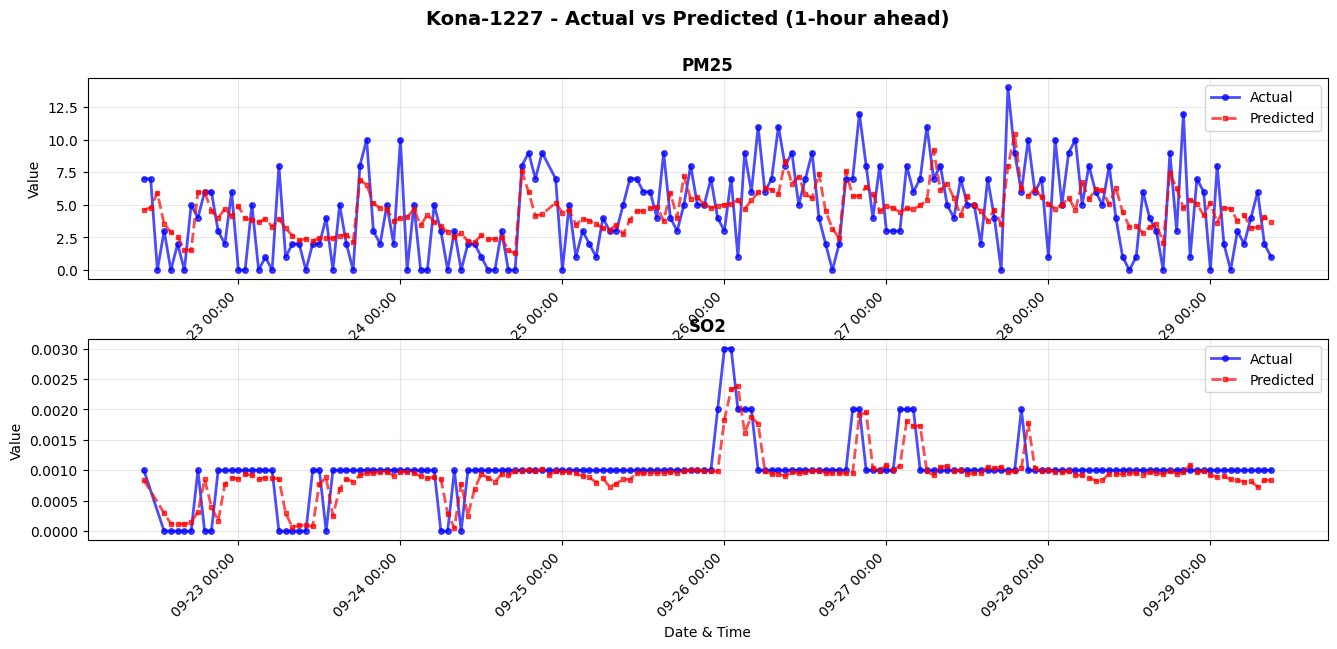

  ✓ Visualization complete for Kona-1227


Jackson NCORE-326 - Last 7 days (169 hours)
Date range: 2025-09-23 to 2025-09-30


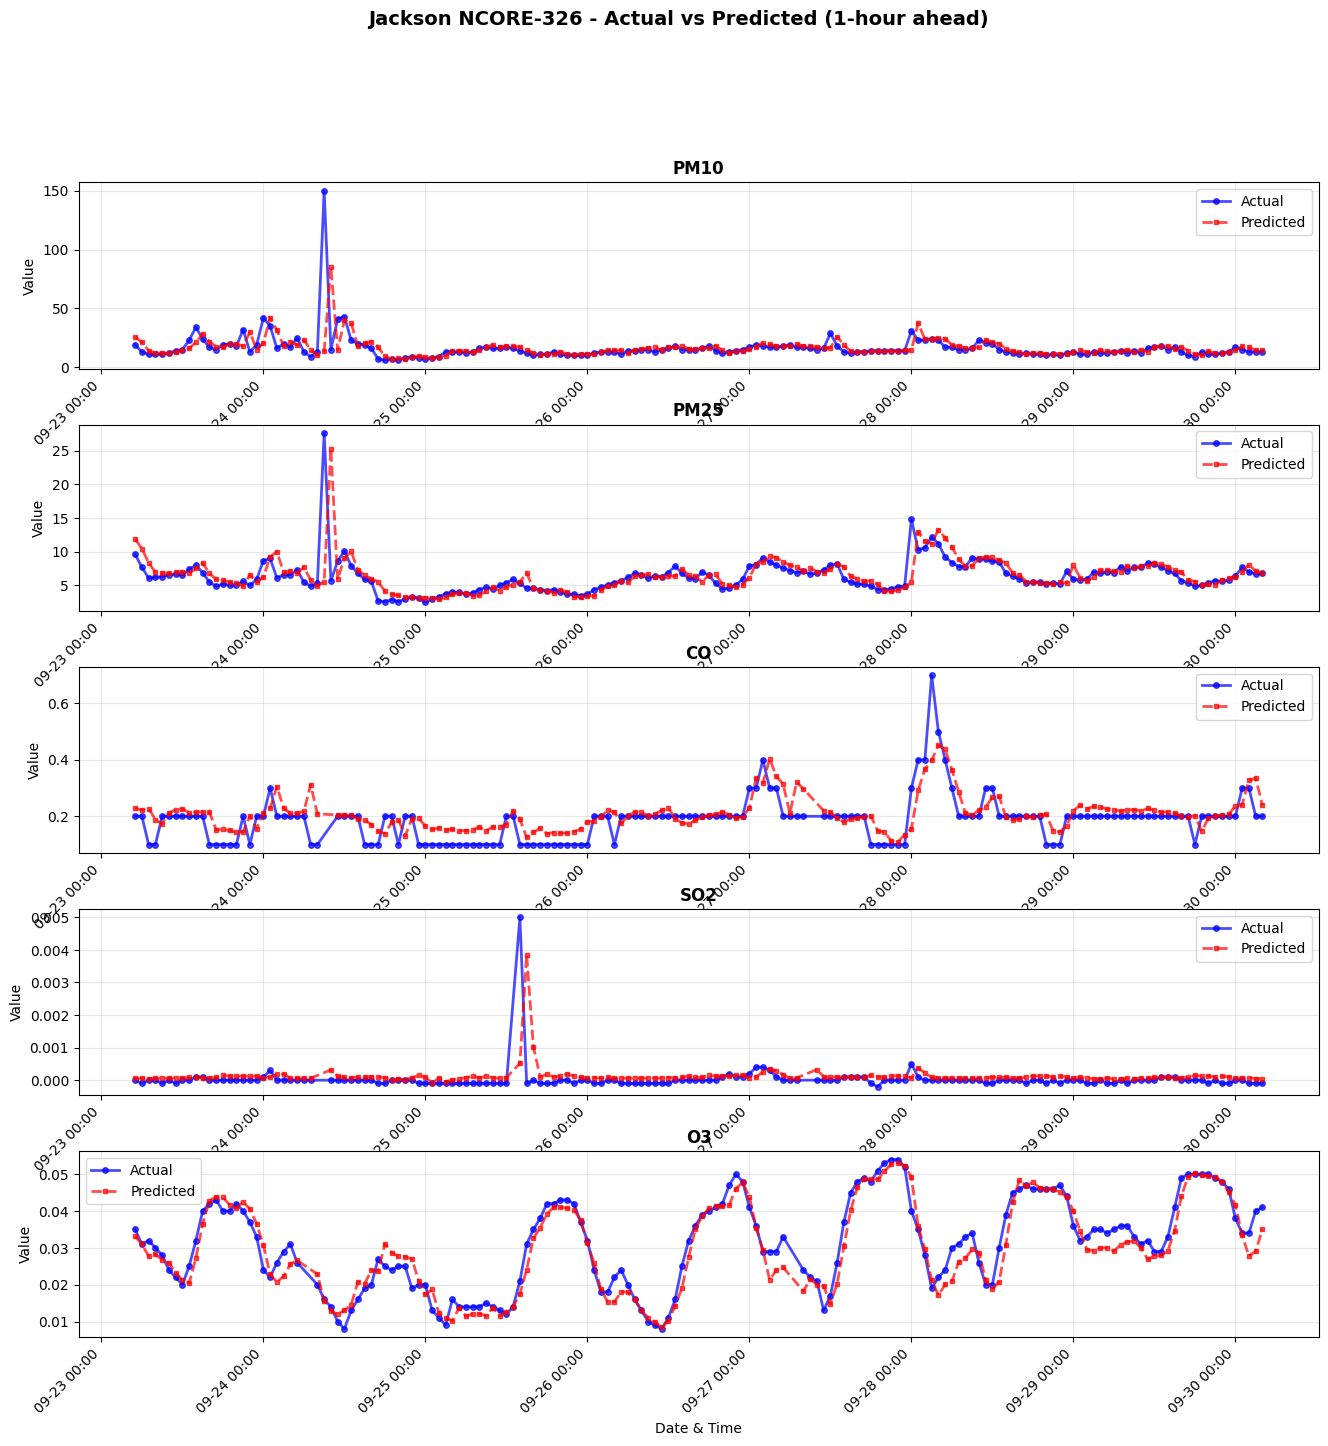

  ✓ Visualization complete for Jackson NCORE-326


Big Piney-1531 - Last 7 days (169 hours)
Date range: 2025-09-23 to 2025-09-30


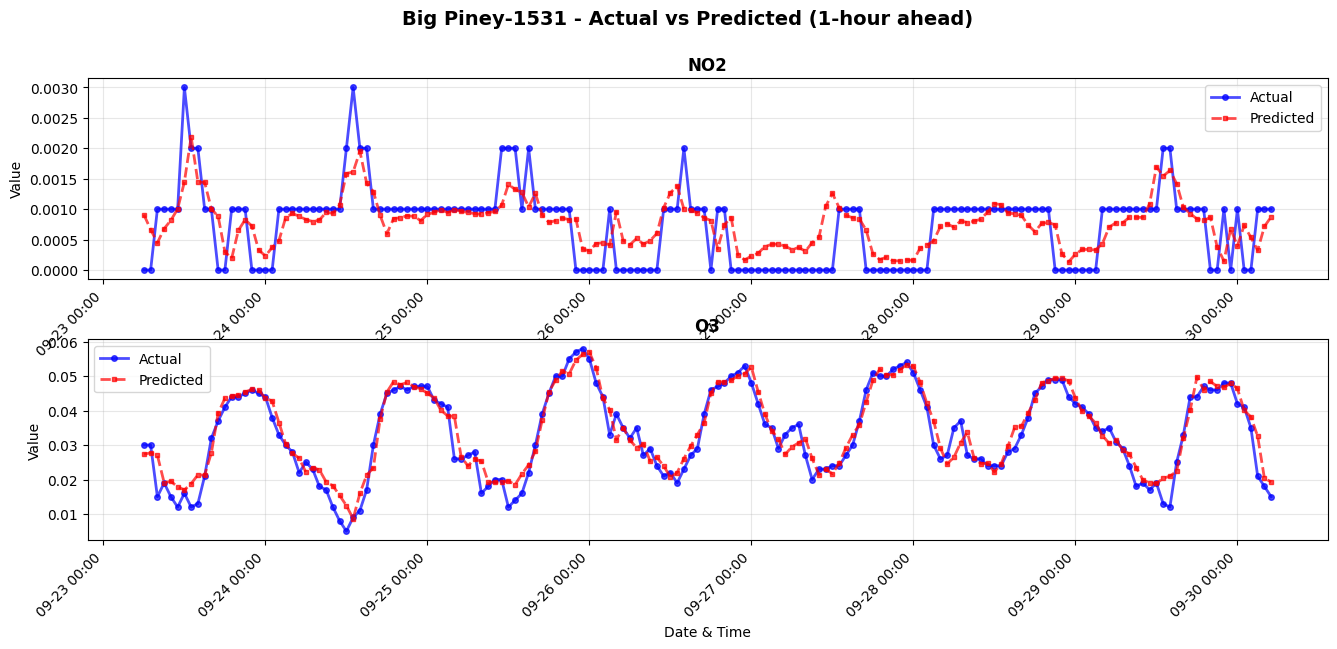

  ✓ Visualization complete for Big Piney-1531



In [ ]:
visualize_predictions(model, feature_df, location_meta, feature_cols, days=7)

In [ ]:
def visualize_forecast_horizon(models, df_featured, location_id, location_metadata, feature_cols):
    """
    Visualize how prediction accuracy degrades over the 48-hour forecast horizon.
    Uses the LAST timestamp in the dataset for each location.

    Args:
        models: Dictionary of trained models
        df_featured: Full featured dataframe
        location_id: Specific location to visualize
        location_metadata: Dictionary with location information
        feature_cols: List of feature column names
    """
    print("\n" + "="*70)
    print("FORECAST HORIZON ANALYSIS (48 hours)")
    print("="*70)

    if location_id not in location_metadata:
        print(f"Location {location_id} not found")
        return

    location_name = location_metadata[location_id]['name']
    available_params = location_metadata[location_id]['parameters']

    # Get last timestamp for this location
    location_df = df_featured[df_featured['location_id'] == location_id].copy()
    latest_data = location_df.iloc[[-1]]

    print(f"\nLocation: {location_name}")
    print(f"Last timestamp: {latest_data['datetime'].values[0]}")
    print(f"Available parameters: {available_params}\n")

    # Prepare features
    X = latest_data[feature_cols]

    # Collect predictions and actuals for each forecast hour
    forecast_data = {}

    for param in available_params:
        if param not in models:
            continue

        model_info = models[param]
        model = model_info['model']

        # Get 48-hour predictions
        predictions = model.predict(X)[0]  # Shape: (48,)

        # Get actual values for all 48 hours
        actuals = []
        for h in range(1, 49):
            target_col = f'{param}_target_{h}h'
            if target_col in latest_data.columns:
                actuals.append(latest_data[target_col].values[0])
            else:
                actuals.append(np.nan)

        forecast_data[param] = {
            'predictions': predictions,
            'actuals': np.array(actuals)
        }

    # Visualize
    n_params = len(forecast_data)
    if n_params == 0:
        print("No data to visualize")
        return

    fig, axes = plt.subplots(n_params, 1, figsize=(14, 4 * n_params))
    if n_params == 1:
        axes = [axes]

    hours = np.arange(1, 49)

    for idx, (param, data) in enumerate(forecast_data.items()):
        ax = axes[idx]

        predictions = data['predictions']
        actuals = data['actuals']

        # Plot
        valid_mask = ~np.isnan(actuals)

        ax.plot(hours[valid_mask], actuals[valid_mask], 'o-',
               label='Actual', color='blue', linewidth=2, markersize=5)
        ax.plot(hours[valid_mask], predictions[valid_mask], 's--',
               label='Predicted', color='red', linewidth=2, markersize=4)

        # Calculate MAE for each forecast hour
        if valid_mask.sum() > 0:
            errors = np.abs(actuals[valid_mask] - predictions[valid_mask])
            avg_mae = np.mean(errors)

            ax.set_title(f'{param.upper()} - 48-Hour Forecast (Avg MAE: {avg_mae:.4f})',
                        fontsize=12, fontweight='bold')
        else:
            ax.set_title(f'{param.upper()} - 48-Hour Forecast',
                        fontsize=12, fontweight='bold')

        ax.set_xlabel('Forecast Hour', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 49)

    plt.suptitle(f'{location_name} - Forecast Horizon Analysis',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✓ Forecast horizon visualization complete\n")


FORECAST HORIZON ANALYSIS (48 hours)

Location: Kona-1227
Last timestamp: 2025-09-29T10:00:00.000000000
Available parameters: ['pm25', 'so2']



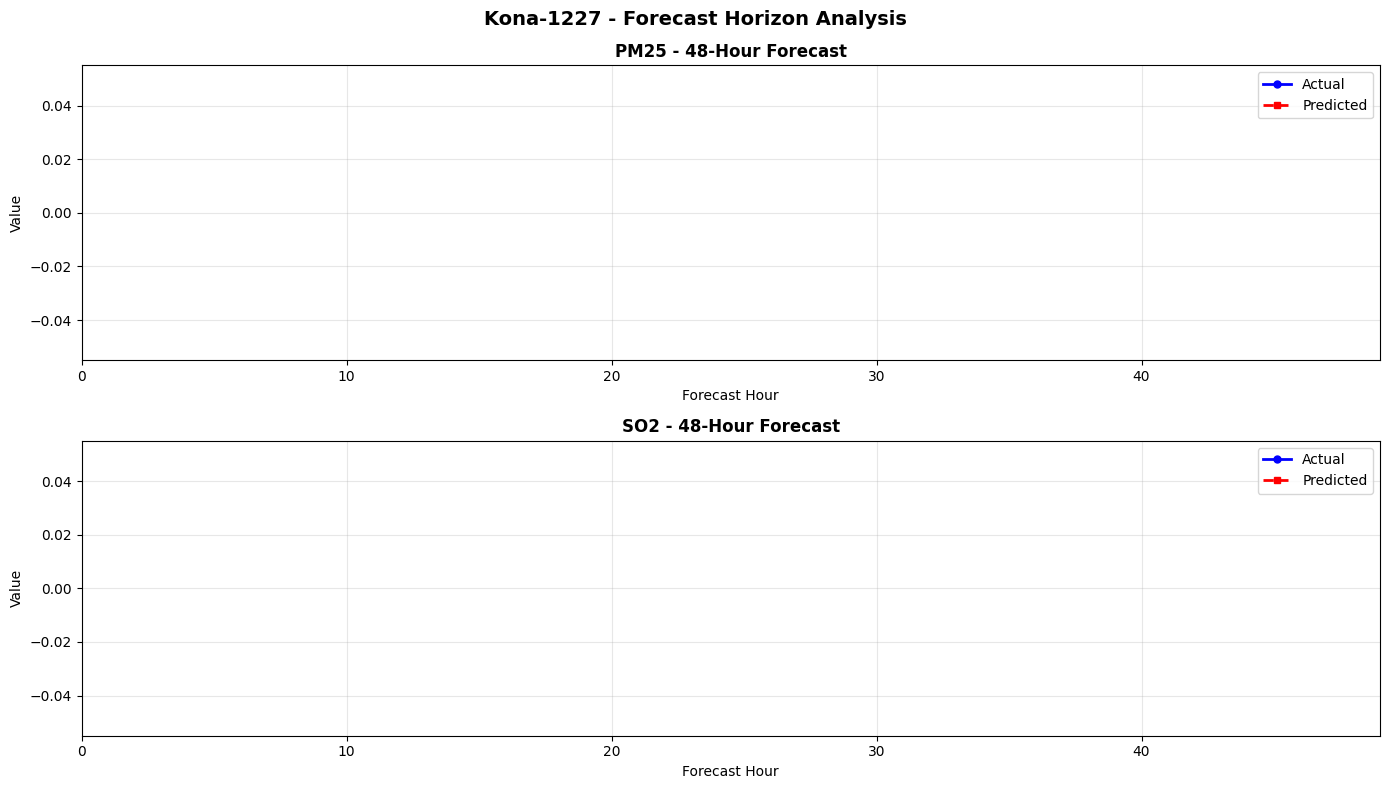

✓ Forecast horizon visualization complete



In [ ]:
visualize_forecast_horizon(model, feature_df, 1227, location_meta, feature_cols)

In [ ]:
def main():
    """
    Complete end-to-end pipeline.
    """
    print("="*70)
    print("AIR QUALITY FORECASTING PIPELINE")
    print("="*70)

    # STEP 1: Load data from multiple locations
    location_folders = '/content/drive/MyDrive/NASA/OPENAQ_DATA'

    location_data = load_multiple_locations(location_folders)

    if not location_data:
        print("Error: No data loaded. Please check folder paths.")
        return

    # STEP 2: Transform to wide format and combine
    combined_df, location_metadata = combine_all_locations(location_data)

    # STEP 3: Feature engineering
    df_featured = engineer_features(combined_df, forecast_hours=48)

    # STEP 4: Prepare train/test split
    X_train, X_test, y_train, y_test, feature_cols, target_cols = prepare_train_test_split(
        df_featured, forecast_hours=48, test_size=0.2
    )

    # STEP 5: Train model
    model = train_model(X_train, y_train)

    # STEP 6: Evaluate model
    results = evaluate_model(model, X_test, y_test, location_metadata, target_cols)

    # STEP 7: Make predictions for each location
    print("\n" + "="*70)
    print("GENERATING FORECASTS")
    print("="*70)

    for location_id in location_metadata.keys():
        forecasts = predict_for_location(
            model, df_featured, location_id, location_metadata, feature_cols, forecast_hours=48
        )

    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)

    return model, location_metadata, df_featured, feature_cols

# Run the pipeline
if __name__ == "__main__":
    # Uncomment below to run (after adjusting folder paths)
    models, location_metadata, df_featured, feature_cols, skipped_locations = main()
    print("\nTo run this pipeline:")
    print("1. Update 'location_folders' in main() with your actual folder paths")
    print("2. Uncomment the last line: models, location_metadata, df_featured, feature_cols, skipped_locations = main()")
    print("3. Run the script")
    print("\nNote: 'models' is now a DICTIONARY with one model per parameter")

AIR QUALITY FORECASTING PIPELINE
Found 4 location folders in /content/drive/MyDrive/NASA/OPENAQ_DATA
Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/1227
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/1227...
Found 9 month folders
Loaded 12886 rows
✓ Loaded Kona-1227 (ID: 1227): 12886 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/326
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/326...
Found 9 month folders
Loaded 31226 rows
✓ Loaded Jackson NCORE-326 (ID: 326): 31226 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/1531
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/1531...
Found 9 month folders
Loaded 25948 rows
✓ Loaded Big Piney-1531 (ID: 1531): 25948 rows

Processing folder: /content/drive/MyDrive/NASA/OPENAQ_DATA/.ipynb_checkpoints
Loading data from /content/drive/MyDrive/NASA/OPENAQ_DATA/.ipynb_checkpoints...
Found 0 month folders
No data loaded

TRANSFORMING TO WIDE FORMAT
Key parameters: ['pm10', '

ValueError: too many values to unpack (expected 2)

**STEP 1: Data Loading**

`load_monthly_data()`: Your original function, enhanced with error handling and progress messages

`load_multiple_locations()`: NEW - Loads multiple locations (Jackson, Kona) and stores them in a dictionary with metadata

Key insight: Each location is loaded separately first, then combined later. This makes it easy to scale to 1000 locations.

**STEP 2: Wide Format Transformation **

`prepare_location_data()`: Converts long format → wide format

Critical: Always creates ALL 5 parameter columns (fills NaN for missing ones)

Jackson gets: `[pm10, pm25, co, so2, o3]` - all with values

Kona gets: `[pm10, pm25, co, so2, o3]` - pm10, co, o3 are NaN


`combine_all_locations()`: Combines all locations into ONE dataframe

Both Jackson and Kona now have same structure (10 columns)

Tracks which parameters each location actually has (metadata)



Result: Single dataframe with ~30K rows, ready for modeling!


**STEP 3: Feature Engineering**

Creates three types of features:

- Temporal: hour, day_of_week, month, cyclical
encodings
- Lag features: Values from 1h, 3h, 6h, 12h, 24h ago for EACH parameter
- Target features: Values 1h-48h in the future for EACH parameter

Key: Lag and target features handle NaN naturally - if pm10 doesn't exist for Kona, all pm10_lag features are NaN.

**STEP 4: Model Training**

Uses `MultiOutputRegressor` with `LightGBM`

240 outputs: 5 parameters × 48 hours = 240 predictions

`LightGBM` handles NaN values automatically (treats them as missing data)

Magic: Model learns "if pm10 exists, use it; if not, rely on other features"

**STEP 5: Evaluation**

Calculates MAE and RMSE for each parameter
Skips metrics for parameters that don't exist in test data
Shows which parameters are being predicted accurately

**STEP 6: Prediction**

Takes any location

Extracts only forecasts for available parameters

For Kona: Returns only pm25 and so2 forecasts (ignores pm10, co, o3)

**STEP 7: Main Pipeline**
Orchestrates everything in order:

`Load → Transform → Engineer → Train → Evaluate → Predict`
How to Use
python
 ```
# 1. Update folder paths
location_folders = [
    'NASA/326',   # Your Jackson path
    'NASA/1227',  # Your Kona path
]

# 2. Run pipeline
model, location_metadata, df_featured, feature_cols = main()

# 3. The model is now trained and ready!
```